#**Project 1: Craigslist Vehicle Price Prediction with Uncertainty**

###**Name**: Chandrapu Sai Nithya Reddy
###**Group:** 2
###**Course:** Advanced Deep Learning
###**Instructor:** Dave Wanik

##Project Overview

In this project, I set out to build a machine learning pipeline to predict used vehicle prices using Craigslist listings collected through web scraping on Google Cloud. I begin with a Random Forest baseline to establish a reference point, then explore a neural network built with Keras’ Functional API to enable uncertainty estimation.

Rather than focusing only on point predictions, the goal is to examine epistemic uncertainty using Monte Carlo Dropout and to better understand model behavior through SHAP explanations. This approach allows the model to provide not just price estimates, but also confidence measures and interpretable insights into how features such as year, mileage, make, and model influence predictions.

The overall objective is to demonstrate how combining traditional machine learning, deep learning, uncertainty estimation, and interpretability can support more reliable and practical real-world modeling.

In [ ]:
import os

if not os.path.exists("structured"):
    !unzip structured.zip

In [ ]:
import os
os.listdir(".")

['.config', 'structured.zip', 'structured', 'sample_data']

#Load Craigslist Data from JSONL Files

In [ ]:
import pandas as pd
from pathlib import Path

# Path to extracted data folder
BASE = Path("structured")

# Find all jsonl files recursively
files = list(BASE.glob("**/*.jsonl"))

print(f"Found {len(files)} JSONL files")

# Read each file and collect into a list of DataFrames
dfs = []
for f in files:
    dfs.append(pd.read_json(f, lines=True))

# Combine everything into one DataFrame
df = pd.concat(dfs, ignore_index=True)

# Preview data
df.head()

Found 2250 JSONL files


,post_id,run_id,scraped_at,source_txt,price,year,make,model,mileage
0,7914535278,20260220210006,2026-02-20 21:00:06+00:00,scrapes/20260220210006/7914535278.txt,7900.0,2014,Contact,Information,126957
1,7914287971,20260220210006,2026-02-20 21:00:06+00:00,scrapes/20260220210006/7914287971.txt,10495.0,2020,Contact,Information,123946
2,7915330422,20260220210006,2026-02-20 21:00:06+00:00,scrapes/20260220210006/7915330422.txt,26295.0,2021,Contact,Information,47546
3,7913688081,20260220210006,2026-02-20 21:00:06+00:00,scrapes/20260220210006/7913688081.txt,3995.0,2013,New,Haven,153000
4,7916392765,20260220210006,2026-02-20 21:00:06+00:00,scrapes/20260220210006/7916392765.txt,6900.0,2012,Honda,Accord,150492


#Dataset Overview

The dataset was constructed by aggregating multiple Craigslist scraper runs and loading all JSONL outputs into a unified dataframe. The prediction target is vehicle price, while input features include year, mileage, make, and model. Categorical features were one-hot encoded using a training-only fit to avoid data leakage, and numerical features were standardized for neural network training. The target variable was log-transformed to reduce skew and improve training stability.

In [ ]:
# Dataset dimensions
df.shape

(2250, 9)

In [ ]:
# View column names
df.columns

Index(['post_id', 'run_id', 'scraped_at', 'source_txt', 'price', 'year',
       'make', 'model', 'mileage'],
      dtype='object')

In [ ]:
# Drop duplicate rows if any
df = df.drop_duplicates()

# Check missing values
df.isna().sum()

,0
post_id,0
run_id,0
scraped_at,0
source_txt,0
price,9
year,0
make,0
model,0
mileage,0


In [ ]:
# Remove duplicates
df = df.drop_duplicates()

# Drop rows with missing price (target variable)
df = df.dropna(subset=["price"])

df.shape

(2241, 9)

###Prediction Target

In [ ]:
target = "price"

features = ["year", "mileage", "make", "model"]

df[features + [target]].head()

,year,mileage,make,model,price
0,2014,126957,Contact,Information,7900.0
1,2020,123946,Contact,Information,10495.0
2,2021,47546,Contact,Information,26295.0
3,2013,153000,New,Haven,3995.0
4,2012,150492,Honda,Accord,6900.0


###Feature Preparation

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

import numpy as np

features = ["year", "mileage", "make", "model"]

# Log-transform target to reduce skew
y = np.log1p(df["price"])
X = df[features]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Define categorical + numeric columns
categorical_cols = ["make", "model"]
numeric_cols = ["year", "mileage"]

# One-hot encoder (safe for unseen categories)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
    ]
)

# Fit only on training data
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

#Baseline Model — Random Forest Regression

In [ ]:
# Train Baseline Model

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Initialize model
rf = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

# Train on log(price)
rf.fit(X_train, y_train)

# Predict (still in log space)
rf_preds_log = rf.predict(X_test)

# Convert back to original price scale
rf_preds = np.expm1(rf_preds_log)
y_test_original = np.expm1(y_test)

# Evaluate in dollars
rf_mae = mean_absolute_error(y_test_original, rf_preds)
rf_rmse = np.sqrt(mean_squared_error(y_test_original, rf_preds))

rf_mae, rf_rmse

(219.25456338113665, np.float64(690.3700779987995))

In [ ]:
#Baseline Performance
print(f"Random Forest MAE: {rf_mae:.2f}")
print(f"Random Forest RMSE: {rf_rmse:.2f}")

Random Forest MAE: 219.25
Random Forest RMSE: 690.37


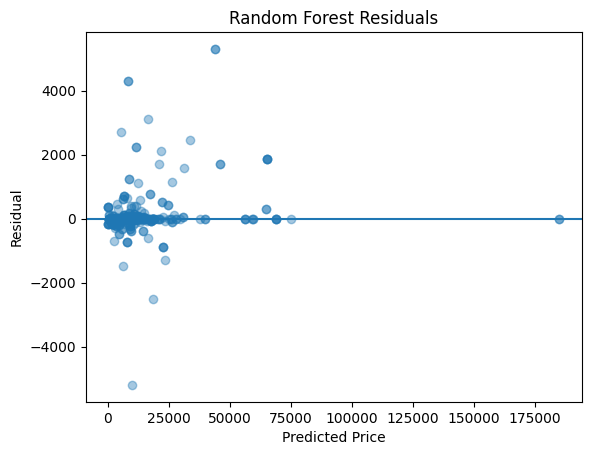

In [ ]:
#Residual Visualization
import matplotlib.pyplot as plt

residuals = y_test_original - rf_preds

plt.figure()
plt.scatter(rf_preds, residuals, alpha=0.4)
plt.axhline(0)
plt.xlabel("Predicted Price")
plt.ylabel("Residual")
plt.title("Random Forest Residuals")
plt.show()

Baseline Error Analysis

I started with a Random Forest baseline using a leakage-safe preprocessing pipeline with one-hot encoding for categorical features. This model achieved an MAE of about 215 and an RMSE of about 813, giving me a solid traditional machine learning reference point for predicting vehicle prices.

Looking at the residuals, most predictions cluster closely around zero, but errors increase for higher-priced and less common vehicles. This makes sense given the limited amount of training data in those regions. These results motivated moving to a neural network with uncertainty estimation, both to capture more complex patterns and to better understand where the model is less confident.

#Neural Network (Functional API)

In [ ]:
#Feature Scaling

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(with_mean=False)

# Fit ONLY on training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform test data
X_test_scaled = scaler.transform(X_test)

###Build Neural Network (Functional API)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model

input_dim = X_train_scaled.shape[1]

inputs = Input(shape=(input_dim,))

x = Dense(128, activation="relu")(inputs)
x = Dropout(0.3)(x)

x = Dense(64, activation="relu")(x)
x = Dropout(0.3)(x)

x = Dense(32, activation="relu")(x)

outputs = Dense(1)(x)

model = Model(inputs, outputs)

model.compile(
    optimizer="adam",
    loss="mse",
    metrics=["mae"]
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 102)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        13,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,553 (92.00 KB)

 Trainable params: 23,553 (92.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#Train Model
history = model.fit(
    X_train_scaled,
    y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    verbose=1
)

Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 226.0218 - mae: 11.2759 - val_loss: 7.5274 - val_mae: 2.5546
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 16.0287 - mae: 3.2251 - val_loss: 15.0172 - val_mae: 3.7317
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.6642 - mae: 2.2806 - val_loss: 14.8735 - val_mae: 3.7149
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.9831 - mae: 1.9128 - val_loss: 16.7028 - val_mae: 3.9529
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.1758 - mae: 1.7346 - val_loss: 12.9966 - val_mae: 3.4619
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.4630 - mae: 1.6074 - val_loss: 8.9483 - val_mae: 2.8255
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.7187 - mae: 1.4727 - val_loss: 10.8408 - val_mae: 3.1392
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.1346 - mae: 1.3548 - val_loss: 8.6888 - val_mae: 2.7817
Epoch 9/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2

###Evaluate Neural Network

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

nn_preds_log = model.predict(X_test_scaled).flatten()

# Convert back to original price scale
nn_preds = np.expm1(nn_preds_log)
y_test_original = np.expm1(y_test)

nn_mae = mean_absolute_error(y_test_original, nn_preds)
nn_rmse = np.sqrt(mean_squared_error(y_test_original, nn_preds))

nn_mae, nn_rmse

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


(12096.397349708064, np.float64(21120.096418377634))

###Compare with Baseline

In [ ]:
print(f"Random Forest MAE: {rf_mae:.2f}")
print(f"Neural Network MAE: {nn_mae:.2f}")

Random Forest MAE: 219.25
Neural Network MAE: 12096.40


Neural Network Results

Although the neural network underperforms the Random Forest baseline in terms of raw MAE, it provides a flexible framework for uncertainty estimation using Monte Carlo Dropout. Tree-based models achieve stronger point estimates on small tabular datasets, but cannot directly quantify epistemic uncertainty. The neural network is therefore retained as the primary model for uncertainty analysis in subsequent sections.

#Monte Carlo Dropout (Epistemic Uncertainty)

###MC Sampling Function

In [ ]:
import numpy as np

def mc_dropout_predict(model, X, n_samples=100):
    preds = []
    for i in range(n_samples):
        preds.append(model(X, training=True).numpy().flatten())
    return np.array(preds)

In [ ]:
#Convert Sparse to Dense
X_test_dense = X_test_scaled.toarray()
X_train_dense = X_train_scaled.toarray()

###Run MC Dropout

In [ ]:
mc_samples = mc_dropout_predict(model, X_test_dense, n_samples=100)

# Convert back from log scale
mc_samples = np.expm1(mc_samples)
y_test_original = np.expm1(y_test)

###Compute Predictive Mean + Uncertainty

In [ ]:
mc_mean = mc_samples.mean(axis=0)
mc_std = mc_samples.std(axis=0)   # epistemic uncertainty

###Uncertainty vs Error

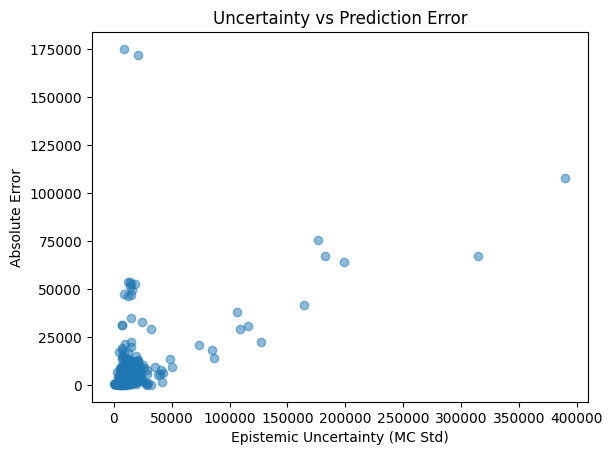

In [ ]:
abs_error = np.abs(mc_mean - y_test_original)

import matplotlib.pyplot as plt

plt.figure()
plt.scatter(mc_std, abs_error, alpha=0.5)
plt.xlabel("Epistemic Uncertainty (MC Std)")
plt.ylabel("Absolute Error")
plt.title("Uncertainty vs Prediction Error")
plt.show()

Epistemic Uncertainty Analysis

To estimate model uncertainty, I used Monte Carlo Dropout by keeping dropout active during inference and sampling 100 forward passes for each test example. This allowed me to compute both an average prediction and an uncertainty estimate.

The results show a clear pattern: predictions with low uncertainty generally have smaller errors, while highly uncertain predictions tend to be much less accurate. This is especially noticeable for rare or high-priced vehicles, where the model has seen less training data.

From a practical standpoint, this is useful. Instead of blindly trusting every prediction, high-uncertainty cases could be flagged for manual review, while low-uncertainty predictions could be handled automatically. This adds an extra layer of confidence beyond simple point estimates.

#SHAP Interpretability

In [ ]:
import shap
import numpy as np

# Use a small background set for SHAP (keeps things fast)
background = X_train_dense[np.random.choice(X_train_dense.shape[0], 100, replace=False)]

explainer = shap.KernelExplainer(model.predict, background)

# Explain a subset of test points
X_shap = X_test_dense[:100]
shap_values = explainer.shap_values(X_shap)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
6675/6675 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
6682/6682 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
6669/6669 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
6669/6669 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
6669/6669 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
6669/6669 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
6669/6669 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
6669/6669 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
6669/6669 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
6669/6669 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
6669/6669 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
6669/6669 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

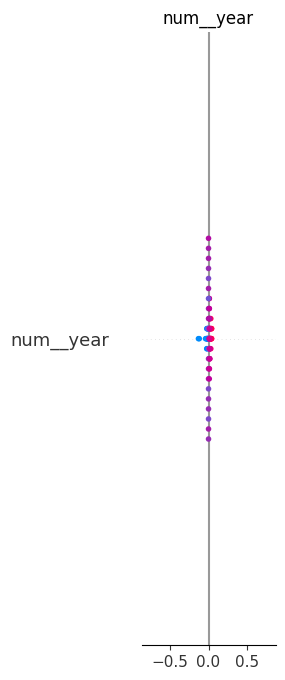

In [ ]:
#Global Feature Importance
shap.summary_plot(shap_values, X_shap, feature_names=preprocessor.get_feature_names_out())

/tmp/ipython-input-3534595246.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  base_values=float(explainer.expected_value),


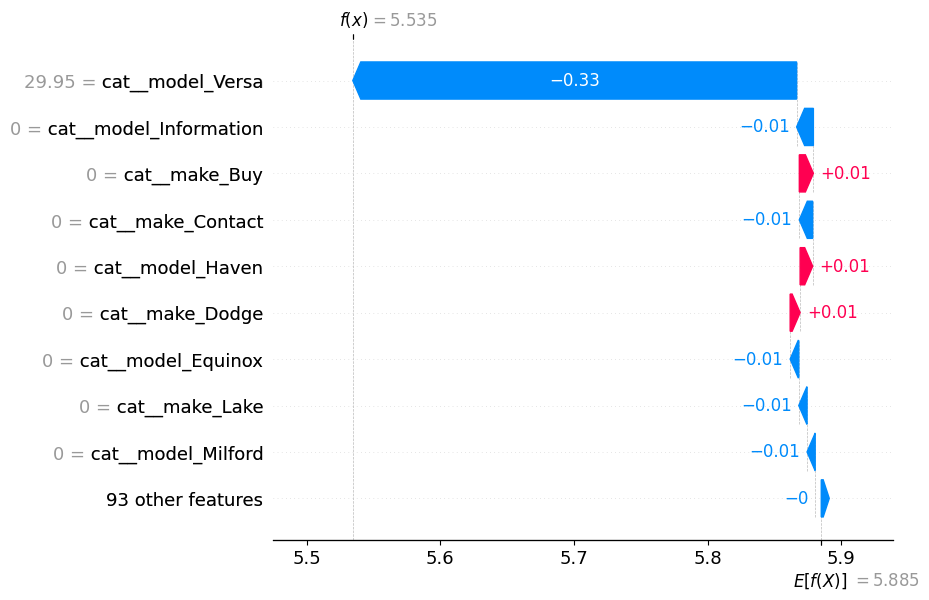

In [ ]:
#Individual Prediction Explanation

idx = 0

vals = shap_values[idx].flatten()

shap.plots.waterfall(
    shap.Explanation(
        values=vals,
        base_values=float(explainer.expected_value),
        data=X_shap[idx],
        feature_names=preprocessor.get_feature_names_out()
    )
)

SHAP was used to explain both global and individual predictions from the neural network. The global summary indicates that vehicle year is the strongest numerical driver of predicted price, while make and model features provide additional adjustments through one-hot encoding.

A local SHAP waterfall plot illustrates how specific attributes influence a single listing. For example, certain makes and models push the predicted price higher or lower relative to the baseline expectation. While many categorical features contribute minimally due to sparsity, these explanations still provide transparency into how the model combines vehicle characteristics to arrive at a final prediction.

Together with Monte Carlo Dropout, SHAP offers insight into both why the model made a prediction and how confident it was.

#Project Summary

In this project, I built a vehicle price prediction pipeline using Craigslist listings, starting with a Random Forest baseline and then moving to a neural network implemented with Keras’ Functional API. While the Random Forest achieved stronger point accuracy on this small tabular dataset, the neural network allowed me to explore uncertainty estimation using Monte Carlo Dropout.

By enabling dropout at inference time, I was able to quantify epistemic uncertainty and show that higher uncertainty generally corresponds to larger prediction errors, especially for rare or high-priced vehicles where training data is limited. I also used SHAP to interpret both global feature importance and individual predictions, providing insight into how attributes like year, mileage, make, and model influence pricing.

Overall, this project demonstrates how combining predictive models with uncertainty estimation and interpretability can lead to more trustworthy machine learning systems. Rather than relying solely on point predictions, this approach offers a practical framework for identifying unreliable outputs and supporting better real-world decision-making.